# Linear least squares fit

## Tasks

Perform a least squares fit of a parabola

$$ y(x) = \theta_0 + \theta_1 x + \theta_2 x^2$$

for the seven independent measurments $(x_i, y_i)$ given by $(-0.75, 1.0 \pm 1.0)$, $(-0.5, 4.0 \pm 1.0)$, $(-0.25, 4.0 \pm 0.5)$, $(0.0, 5.5 \pm 0.5)$, $(0.25, 4.5 \pm 0.5)$, $(0.5, 5.5 \pm 1.0)$, $(0.75, 3.0 \pm 1.0)$. 

a) Determine the best fit parameters $\hat \theta_i$ and their covariances using the formula for linear least squares fits.

b) Determine the $\chi_\mathrm{obs}^2$ for the best fit parameter. What is the number of degrees of freedom? Plot the $\chi^2$ distribution and indicate $\chi_\mathrm{obs}^2$ in this plot (e.g. by drawing a line at this value).
What is the $p$-value for this fit?

c) Plot the fitted parabola and the $1\sigma$ error band around it as obtaind from the error propagation formula $\sigma_y^2 = A^\mathrm{T} U A$. What is the predicted value $y$ at $x=1$ and its uncertainty?

d) Compare the fit result and the covariance matrix with the results obtained with iminuit. Do the results agree?

e) Determine the $p$-value for a straight-line fit. Is this an acceptable description of the data?


### Hints

1) The following numpy functions might come in very handy
* diagonal matrix from vector v in numpy: *A = np.diagflat(v)*
* matrix from column vectors v0, v1, v2: *A = np.column_stack((v0, v1, v2))*
* multiplication of matrices A and B in numpy: *C = A.dot(B)*
* transposed matrix: *A_T = np.transpose(A)*
* inverse matrix: *A_inv = inv(A)*, this requires *from numpy.linalg import inv*

2) It might be useful to write a function which returns the uncertainty $\sigma_y$ for a numpy array of $x$ values. A function $f$ that only works for a scalar value $x$ can be vectorized (i.e., it works also for numpy arrays) with *numpy.vectorize*.

3) Data points with error bars can be drawn with *plt.errorbar(x, y, yerr=sigma_y)*

4) A band between $y$ values can be drawn with the aid of *matplotlib.pyplot.fill_between*

## Comments on Python's `iminuit`

The KIP service has iminuit version 1.3.8. Please note that the most recent version is $\geq2.0.0$ and that the [documentation](https://iminuit.readthedocs.io/en/stable/) applies to *that* version. Some backward-incompatible changes have been introduced, some of which changed some interfaces. For your tasks that mainly affects the `minuit.Minuit` constructor. The following shows the construction of a `Minuit` object for version 1.3.8 (in case you use the KIP service or a version $<2.0.0$) and $\geq2.0.0$ (in case you use another service implementing a higher version), respectively.
```python
from iminuit import Minuit

def func(par1, par2, ..., parN):
    return minimise_something(par1, par2, ..., parN)

# least squares method: errordef=1
# likelihood method: errordef=0.5
m = Minuit(func, par1=0.1, par2=0.1, ..., parN=0.1, errordef=1)
```

And this would be the equivalent workflow for versions >2.0.0
```python
from iminuit import Minuit

def func(par1, par2, ..., parN):
    return minimise_something(par1, par2, ..., parN)

# least squares method: errordef=Minuit.LEAST_SQUARES
# likelihood method: errordef=Minuit.LIKELIHOOD

# add errordef as an attribute of your defined minimisation function which will be checked for when optimised
func.errordef = Minuit.LEAST_SQUARES
m = Minuit(func, par1=0.1 par2=0.1, ..., parN=0.1)
```

Another (potenitally) Jupiter related *feature* is the fact that `m.migrad()`, `m.matrix()`, `m.minos()` etc. can yield a nice summary of the respective procedure. However, in order to show it, either of these methods (and potentially others in case you use them) have to be *the last line of a code cell*. If there is *anything* coming afterwards, the output will not be printed, hence, for anything that follows, it is recommended to start a new code cell.


## Solution

In [1]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
#import matplotlib.mlab as mlab
%matplotlib inline
import numpy as np
from numpy import exp, log, pi, sin
from scipy.special import gamma, factorial
from scipy.integrate import quad
#from scipy.optimize import curve_fit 
#from scipy.stats import chi2
#from glob import glob
#from astropy.io import fits
#from astropy.visualization import simple_norm
#import matplotlib.patches as mpatches
#import statistics as st
#import pandas as pd
#from scipy.signal import find_peaks
from sympy import *
import sympy as sp
from IPython.display import display, Latex



from numpy.linalg import inv
from iminuit import Minuit
from numpy import transpose as tp

In [2]:
# Default plot style
rcParams['axes.linewidth'] = 2
rcParams['axes.edgecolor'] = 'grey'
rcParams['axes.grid'] = True
rcParams['grid.linestyle'] = (5,10)

rcParams['figure.figsize'] = (12, 7)
rcParams['axes.titlesize'] = 18
rcParams['axes.labelsize'] = 14
rcParams['legend.fontsize'] = 14
rcParams['xtick.labelsize'] = 14
rcParams['ytick.labelsize'] = 14

In [3]:
# data
x = np.array([-0.75, -0.5, -0.25, 0., 0.25, 0.5, 0.75])
y = np.array([1., 4.0, 4., 5.5, 4.5, 5.5, 3])
sigma_y = np.array([1, 1, 0.5, 0.5, 0.5, 1, 1])

a) We determine the best fit parameters $\theta_i$ and their covariances for a parabola using the values given previously. In the method of least squares, we're interested in minimizing $\chi^2$. Luckily, since the parameters appear linearly in the function, we can use a closed form for $f(x, \vec{\theta})$:

$$ f(\vec{x}, \vec{\theta}) = \sum_{i = 0}^2 a_i(x) \theta_i = \sum_{i = 0}^2 \theta_i x^i $$.

A simple parameter comparison tells us that $a_i(x) = x^i$. Our next goal is to determine

$$ \chi^2 = (\vec{y} - \vec{\mu})^T \textbf{C}^{-1} (\vec{y} - \vec{\mu}) $$

where $\vec{y}$ are the $n = 7$ measurements and $\vec{\mu}$ are the values our function $\vec{\mu} = f(\vec{x}, \vec{\theta})$ takes. In our case, we simplify $\vec{\mu} = \textbf{A} \cdot \vec{\theta}$, such that we find a minimum (according to the script) at

$$ \vec{\theta} = (\textbf{A}^T \textbf{C}^{-1} \textbf{A})^{-1} \textbf{A}^T \textbf{C}^{-1} \, \vec{y} := \textbf{G} \vec{y}. $$

The covariance matrix of the parameters is

$$ \textbf{C}_\theta = \textbf{G} \textbf{C} \textbf{G}^T. $$

To achieve our goal we then have to determine our matrix $\textbf{A}$ and $\textbf{C}$ and do the rest with python. $\textbf{A}$ is given by $A_{ij} = a_j(x_i)$

In [4]:
# A, C
A = np.column_stack((x ** 0, x, x ** 2))
C = np.diag(sigma_y ** 2)
# G
G = inv(tp(A).dot(inv(C)).dot(A)).dot(tp(A)).dot(inv(C))
# C_theta
C_theta = G.dot(C).dot(tp(G))

And finally, the best parameters are given by $\vec{\theta} = \textbf{G} \vec{y}$.

In [5]:
theta = G.dot(y)

# Display results
display(Latex('${} = {} $'.format('\\theta',latex(Matrix(theta.round(3))))))
display(Latex('$C_\\theta \\approx {}$'.format(latex(Matrix(C_theta.round(3))))))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

b) Now we determine the $\chi^2_{\text{obs}}$ value for the best fit parameter. The number of degrees of freedom is the amount of measurements minus the amount of parameters, so in our case dof = 4. In the previous text, we showed a formula for $\chi^2$ that is still valid now, we can input the things we already kow into it. When we plot the $\chi^2$ distribution, it's important to note that we're talking about the probability density of $\chi^2$, not $\chi^2$ itself.

<IPython.core.display.Latex object>

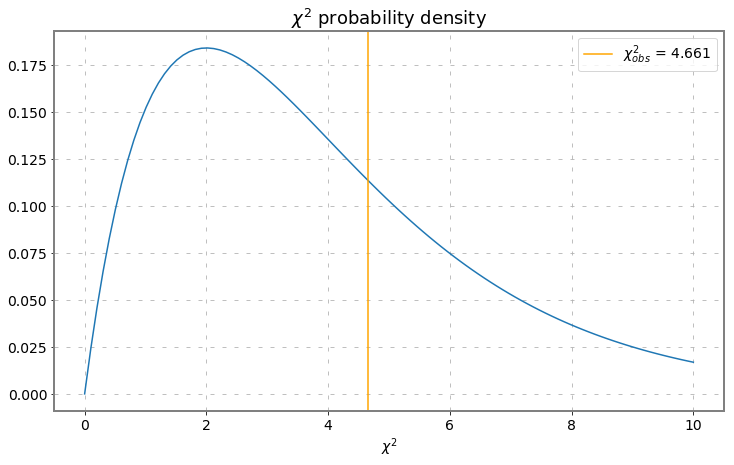

In [6]:
# calculating chi_squared_obs
chi_sq_obs = tp(y - A.dot(theta)).dot(inv(C)).dot(y - A.dot(theta))

display(Latex('${} ={}$'.format('\\chi^2_{obs}', chi_sq_obs.round(3))))

# defining the chi_squared distribution with dof = n
z_var = np.linspace(0, 10, 100)
def chi_sq_pdf(z):
    return z ** (4 / 2 - 1) * np.exp(- z / 2) / (2 ** (4 / 2) * gamma(4 / 2)) 


# plotting the chi_squared distribution
fig, ax = plt.subplots()
ax.plot(z_var, chi_sq_pdf(z_var))
ax.set_title('$\\chi^2$ probability density')
ax.set_xlabel('$\\chi^2$')
ax.axvline(chi_sq_obs, color = 'orange', 
           label = '$\chi^2_{obs}$ = ' + str(chi_sq_obs.round(3)))

ax.legend(loc = 'best')
fig.show()

And now we determine the p-number for this $\chi^2$ value. It's defined as 1 minus the integral of the $\chi^2$ distribution until that point

In [7]:
p_number = 1 - quad(chi_sq_pdf, 0, chi_sq_obs)[0]
display(Latex('$p = {}.$'.format(np.round(p_number,3))))

<IPython.core.display.Latex object>

c) Now we plot the fitted parabola and the $1 \sigma$ error band around it as obtained from $\sigma_y^2 = \textbf{A}^T \textbf{C}_\theta \textbf{A}$

In [8]:
print(C_theta)

[[ 9.73025048e-02  8.67361738e-19 -2.62042389e-01]
 [ 8.67361738e-19  4.70588235e-01  6.93889390e-18]
 [-2.62042389e-01 -4.85722573e-17  1.97302505e+00]]


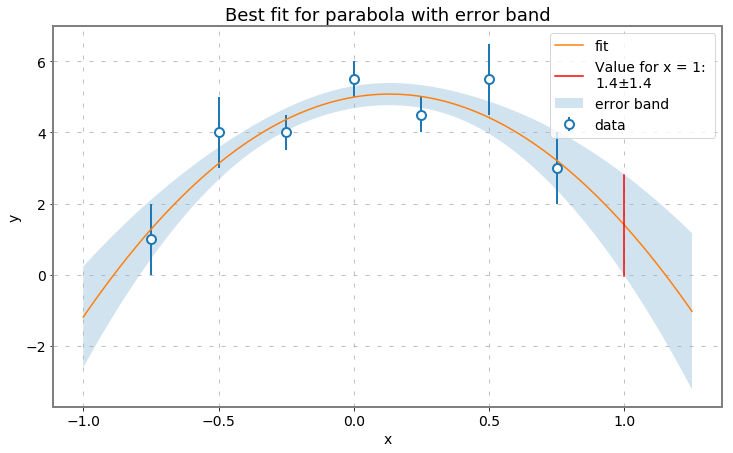

In [9]:
# First we define the parabola
def parabola(x, theta_0, theta_1, theta_2):
    return theta_0 + theta_1 * x + theta_2 * x ** 2

''' Since we're interested in the full error band, we will want to estimate the
uncertainty for finer intervals as well
'''
def sigma(x_var):
    A = np.array([1, x_var, x_var ** 2], dtype='object')
    return np.sqrt(tp(A).dot(C_theta).dot(A))

# Define our range
x_new = np.linspace(-1, 1.25, 100)

# Plot
plt.title('Best fit for parabola with error band')
plt.xlabel('x')
plt.ylabel('y')
plt.errorbar(x, y, yerr = sigma_y, fmt='o', fillstyle = 'none', label='data',
            markeredgewidth = 2, markersize = 9, mfc='w', linewidth = 2)
plt.plot(x_new, parabola(x_new, *theta), label = 'fit')
plt.fill_between(x_new, parabola(x_new, *theta) + sigma(x_new),
                parabola(x_new, *theta) - sigma(x_new), 
                 label = 'error band', alpha = 0.2)
y_min = (parabola(1, *theta) - sigma(1) 
         - plt.axis()[2]) / (plt.axis()[3] - plt.axis()[2])
y_max = (parabola(1, *theta) + sigma(1) 
         - plt.axis()[2]) / (plt.axis()[3] - plt.axis()[2])
plt.axvline(x = 1, ymin = y_min, ymax = y_max, color = 'red', 
            label = 'Value for x = 1: \n' 
            + str(np.round(parabola(1, *theta), 1)) + '$\pm$' 
            + str(np.round(sigma(1), 1)))



plt.legend(loc = 'best')
plt.show()

#fig, ax = plt.subplots()
#ax.plot(x, parabola(x, *theta))

d) Now we'll compare these results with what we get using the iminuit functions. The function we want to minimise is

$$ \chi^2 = \sum_{i = 1}^n \dfrac{(y - f(x, \theta))^2}{\sigma_y^2} $$

with respect to the parameters $\theta$.

In [10]:
# define chi_sq as a function of parameters
def chi_sq_theta(theta_0, theta_1, theta_2):
    return np.sum((y - parabola(x, theta_0, theta_1, theta_2)) ** 2 
                  / sigma_y ** 2)

chi_sq_theta.errordef = Minuit.LEAST_SQUARES
m = Minuit(chi_sq_theta, theta_0 = 5, theta_1 = 0, theta_2 = 4)
m.migrad()
m.hesse()
m.minos()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 4.661                      │              Nfcn = 129              │
│ EDM = 4.55e-23 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬─────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name    │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼─────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ theta_0 │   4.99    │   0.31    │   -0.31    │    0.31    │         │         │       │
│ 1 │ theta_1 │    1.3    │    0.7    │    -0.7    │    0.7     │         │         │       │
│ 2 │ theta_2 │   -4.9    │    1.4    │    -1.4    │    1.4     │         │         │       │
└───┴─────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────┬───────────────────────┬───────────────────────┐
│          │        theta_0        │        theta_1        │        theta_2        │
├──────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┤
│  Error   │   -0.31   │   0.31    │   -0.7    │    0.7    │   -1.4    │    1.4    │
│  Valid   │   True    │   True    │   True    │   True    │   True    │   True    │
│ At Limit │   False   │   False   │   False   │   False   │   False   │   False   │
│ Max FCN  │   False   │   False   │   False   │   False   │   False   │   False   │
│ New Min  │   False   │   False   │   False   │   False   │   False   │   False   │
└──────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┘
┌─────────┬────────────────────────────┐
│         │  theta_0  theta_1  theta_2 │
├─────────┼────────────────────────────┤
│ theta_0 │   0.0973 1.77e-10   -0.262 │
│ theta_1 │ 1.77e-10    0.471 7.95e-10 │
│ theta_2 │   -0.262 7.95e-10     1.97 │
└─────────┴────────────────────────────┘

We gather that both methods are equivalent to each other after comparing the relevant values and tables.

e) Now we perform a similar task for a straight line fit and determine the p value for this assumption

In [11]:
# A, C
A_l = np.column_stack((x ** 0, x)) # Slight change, now only linear
C = np.diag(sigma_y ** 2) # We had already defined this, but as a reminder
# G
G_l = inv(tp(A_l).dot(inv(C)).dot(A_l)).dot(tp(A_l)).dot(inv(C))
# C_theta
C_theta_l = G_l.dot(C).dot(tp(G_l))

# theta
theta_l = G_l.dot(y)

# Display results
display(Latex('${} = {} $'.format('\\theta',latex(Matrix(theta_l.round(3))))))
display(Latex('$C_\\theta \\approx {}$'.format(latex(Matrix(C_theta_l.round(3))))))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

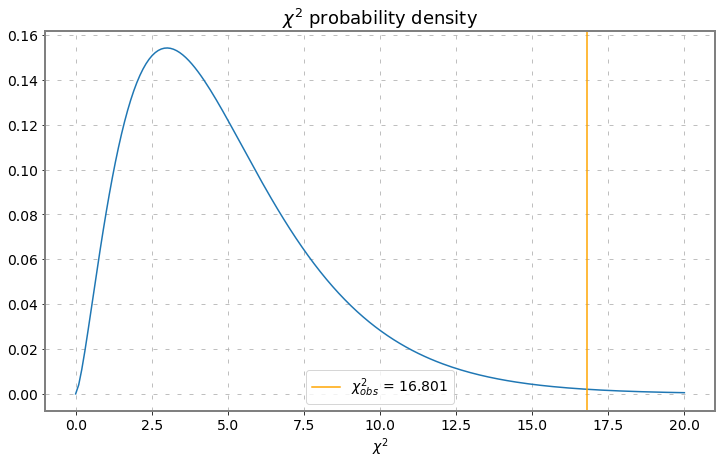

In [12]:
# calculating chi_squared_obs
chi_sq_obs_l = tp(y - A_l.dot(theta_l)).dot(inv(C)).dot(y - A_l.dot(theta_l))

display(Latex('${} ={}$'.format('\\chi^2_{obs}', chi_sq_obs_l.round(3))))

# defining the chi_squared distribution with dof = 5
z_var = np.linspace(0, 20, 200)
def chi_sq_pdf_l(z):
    return z ** (5 / 2 - 1) * np.exp(- z / 2) / (2 ** (5 / 2) * gamma(5 / 2)) 


# plotting the chi_squared distribution
fig, ax = plt.subplots()
ax.plot(z_var, chi_sq_pdf_l(z_var))
ax.set_title('$\\chi^2$ probability density')
ax.set_xlabel('$\\chi^2$')
ax.axvline(chi_sq_obs_l, color = 'orange', 
           label = '$\chi^2_{obs}$ = ' + str(chi_sq_obs_l.round(3)))

ax.legend(loc = 'best')
fig.show()

In [13]:
p_number_l = 1 - quad(chi_sq_pdf_l, 0, chi_sq_obs_l)[0]
display(Latex('$p = {}.$'.format(np.round(p_number_l,3))))

<IPython.core.display.Latex object>

A p-value of 0.005 indicates that this fit isn't appropriate for the measurements.